In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import ast


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier



import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek


Importing the admisssions dataset to start pre-processing

In [2]:
df = pd.read_csv(r"../datasets/anonymised admissions dataset")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        656 non-null    int64 
 1   ID                656 non-null    int64 
 2   search_term       656 non-null    object
 3   location          642 non-null    object
 4   headline          655 non-null    object
 5   current_position  596 non-null    object
 6   current_company   640 non-null    object
 7   past_company_1    625 non-null    object
 8   past_company_2    584 non-null    object
 9   school_1          639 non-null    object
 10  school_2          589 non-null    object
 11  top_skill_1       610 non-null    object
 12  top_skill_2       607 non-null    object
 13  top_skill_3       604 non-null    object
 14  bio               464 non-null    object
 15  experiences       641 non-null    object
 16  schools           639 non-null    object
 17  skills          

## Preprocessing ##

We start by handling null values

In [4]:
#removing values where both school_1 and school_2 are null
df1=df.copy()


df1.dropna(subset=["school_1", "school_2"], inplace=True)

## Feature Engineering 

Creating a column to capture whether they have studied at the University of Cambridge.

Creating a column to record other universities attended.

To do this, we start by filtering out for only records where either school_1 or school_2 contain "Cambridge"

In [5]:
df2=df1.copy()

df2=df2.loc[df2["school_1"].str.contains("Cambridge", case=False, na=False) |
        df2["school_2"].str.contains("Cambridge", case=False, na=False)]

# Creating a new column to record the non-Cambridge university attended

df2["non-Cambridge uni"] = np.where(
    df2["school_1"].str.contains("Cambridge", case=False, na=False), 
    df2["school_2"],  # If "Cambridge" is in school_1, use school_2
    df2["school_1"]   # Else, use school_1
)

df2["Cambridge?"] = 1


We now repeat the feature engineering process for records that do not contain "Cambridge."

Since both school records include two different university fields, we have two approaches for creating the dataset:

1. Duplication Method (dup_df): Data from two schools per profile was split into separate rows, increasing diversity but introducing some synthetic noise.

2. Arbitrary Method (arb_df): Only one school (typically the most recent) was selected, ensuring greater reliability at the expense of some nuance.

For this project, both datasets were generated, and similar models were run on each to better explore the nuances within the data.

In [6]:
df3 = df1[~df1.index.isin(df2.index)] #generating a non-Cambridge dataset

In [7]:
#Duplication method : 

dup_df = pd.DataFrame()  

for index, row in df3.iterrows():
    schools = [row['school_1'], row['school_2']]  
    for school in schools:
        new_row = row.copy()  
        new_row['school_1'] = school  
        dup_df = pd.concat([dup_df, pd.DataFrame([new_row])], ignore_index=True)
        
dup_df["non-Cambridge uni"] =dup_df["school_1"]
dup_df["Cambridge?"] =0


dup_df=pd.concat([dup_df,df2], ignore_index=True)


In [8]:
# Arbitrary method :

arb_df=df3.copy()
arb_df["non-Cambridge uni"]=arb_df["school_1"]
arb_df["Cambridge?"]=0

arb_df=pd.concat([arb_df,df2], ignore_index=True)

I wanted to investigate the importance of going to a Russel group university affects admissions to Cambridge.

To reflect the difference in prestige, I have grouped the universities of Oxford and Cambridge differently to other Russel group universities.

In [9]:
Oxbridge =["University of Oxford","University of Cambridge"]
Russel = [
    "University of Birmingham",
    "University of Bristol",
    "Cardiff University",
    "Durham University",
    "University of Edinburgh",
    "University of Exeter",
    "University of Glasgow",
    "Imperial College London",
    "King's College London",
    "University of Leeds",
    "University of Liverpool",
    "The London School of Economics and Political Science (LSE)",
    "University of Manchester",
    "Newcastle University",
    "University of Nottingham",
    "University of Sheffield",
    "University of Southampton",
    "UCL",
    "University of Warwick",
    "University of York",
    "Queen Mary University of London",
    "Queen's University Belfast"
]

In [10]:
def classify_uni(uni):
    if uni in Russel:
        return 1
    elif uni in Oxbridge:
        return 2
    else:
        return 0
    
dup_df["Uni Class"] = dup_df["non-Cambridge uni"].apply(classify_uni)
arb_df["Uni Class"]=arb_df["non-Cambridge uni"].apply(classify_uni)

During data exploratory analysis, I found that data in the "experiences" feature is a list of dictionaries currently being stored as a string. To extract meaningful information, I have created fields capturing the months of experience in data related fields and leadership positions. 

In [11]:
dup_df['experiences'] = dup_df['experiences'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
arb_df['experiences']=arb_df['experiences'].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [12]:
from datetime import datetime


def calculate_months(start, end):
    """Calculate the difference in months between two dates."""
    if end is None:
        end = datetime.today().strftime('%Y-%m-%d') 
    start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')
    
    return (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)


In [13]:
def extract_experience(experiences):
    data_months = 0
    leader_months = 0

    if isinstance(experiences, list):
        for exp in experiences:
            start = exp.get('start_date')
            end = exp.get('end_date')
            title = exp.get('title', '').lower()

            if not start:
                continue

            months = calculate_months(start, end)

            if any(word in title for word in ['data', 'analytics', 'ml', 'ai', 'scientist', 'engineer']):
                data_months += months

            if any(word in title for word in ['president', 'vice president', 'founder', 'head', 'CEO', 'COO']):
                leader_months += months

    return data_months,leader_months

In [14]:
dup_df[['data_months', 'leader_months']] = dup_df['experiences'].apply(lambda x: pd.Series(extract_experience(x)))

arb_df[['data_months', 'leader_months']] = dup_df['experiences'].apply(lambda x: pd.Series(extract_experience(x)))

Adding in the QS World University Rankings for 2025

In [15]:
qs=pd.read_csv(r"../datasets/qs-world-rankings-2025")


In [16]:
dup_df = dup_df.merge(qs[['Institution Name', '2025 Rank']], 
                         how='left', 
                         left_on='non-Cambridge uni', 
                         right_on='Institution Name')

arb_df = arb_df.merge(qs[['Institution Name', '2025 Rank']], 
                         how='left', 
                         left_on='non-Cambridge uni', 
                         right_on='Institution Name')

In this process, it was found that a number of records were falling out due to small differences in the university names. To handle these, I considered using a fuzzy match but chose against it since some of the values in "non-Cambridge uni" are that of sixth form colleges. To avoid incorrectly matching these, I chose to handle most fallouts by hand. 

While this was time inefficient, it gave me greater control over the quality of my data.

In [17]:
unmatched = dup_df[dup_df['2025 Rank'].isna()]['non-Cambridge uni'].unique()

In [18]:
#for dup_df:

dup_df.loc[dup_df["non-Cambridge uni"] == "University of Warwick", "2025 Rank"] = 69
dup_df.loc[dup_df["non-Cambridge uni"] == "University of Warwick - Warwick Business School", "2025 Rank"] = 69
dup_df.loc[dup_df["non-Cambridge uni"] == "Massachusetts Institute of Technology", "2025 Rank"] = 1
dup_df.loc[dup_df["non-Cambridge uni"] == "University of Sydney", "2025 Rank"] = 18
dup_df.loc[dup_df["non-Cambridge uni"] == "Indian Institute of Technology, Madras", "2025 Rank"] = 227
dup_df.loc[dup_df["non-Cambridge uni"] == "Trinity College Dublin", "2025 Rank"] = 87
dup_df.loc[dup_df["non-Cambridge uni"] == "Cardiff University / Prifysgol Caerdydd", "2025 Rank"] = 186
dup_df.loc[dup_df["non-Cambridge uni"] == "City St George’s, University of London", "2025 Rank"] = 352
dup_df.loc[dup_df["non-Cambridge uni"] == "Københavns Universitet - University of Copenhagen", "2025 Rank"] = 100
dup_df.loc[dup_df["non-Cambridge uni"] == "University of Exeter", "2025 Rank"] = 169
dup_df.loc[dup_df["non-Cambridge uni"] == "University of Naples ‘Parthenope’", "2025 Rank"] = 1100
dup_df.loc[dup_df["non-Cambridge uni"] == "Saïd Business School, University of Oxford", "2025 Rank"] = 3
dup_df.loc[dup_df["non-Cambridge uni"] == "University of Canterbury", "2025 Rank"] = 261
dup_df.loc[dup_df["non-Cambridge uni"] == "UC Santa Barbara", "2025 Rank"] = 178
dup_df.loc[dup_df["non-Cambridge uni"] == "Middlesex University (Hornsey College of Art)", "2025 Rank"] = 725
dup_df.loc[dup_df["non-Cambridge uni"] == "University of Hamburg", "2025 Rank"] = 191
dup_df.loc[dup_df["non-Cambridge uni"] == "Royal Holloway, University of London", "2025 Rank"] = 477
dup_df.loc[dup_df["non-Cambridge uni"] == "University of Benin", "2025 Rank"] = 1350
dup_df.loc[dup_df["non-Cambridge uni"] == "Vellore Institute of Technology", "2025 Rank"] = 795
dup_df.loc[dup_df["non-Cambridge uni"] == "Imperial College Business School", "2025 Rank"] = 2
dup_df.loc[dup_df["non-Cambridge uni"] == "Universidad Politécnica de Madrid", "2025 Rank"] = 321
dup_df.loc[dup_df["non-Cambridge uni"] == "Kingston University", "2025 Rank"] = 605
dup_df.loc[dup_df["non-Cambridge uni"] == "Univeristy of Cambridge", "2025 Rank"] = 5
dup_df.loc[dup_df["non-Cambridge uni"] == "Delhi University", "2025 Rank"] = 328

#for arb_df

arb_df.loc[arb_df["non-Cambridge uni"] == "University of Warwick", "2025 Rank"] = 69
arb_df.loc[arb_df["non-Cambridge uni"] == "University of Warwick - Warwick Business School", "2025 Rank"] = 69
arb_df.loc[arb_df["non-Cambridge uni"] == "Massachusetts Institute of Technology", "2025 Rank"] = 1
arb_df.loc[arb_df["non-Cambridge uni"] == "University of Sydney", "2025 Rank"] = 18
arb_df.loc[arb_df["non-Cambridge uni"] == "Indian Institute of Technology, Madras", "2025 Rank"] = 227
arb_df.loc[arb_df["non-Cambridge uni"] == "Trinity College Dublin", "2025 Rank"] = 87
arb_df.loc[arb_df["non-Cambridge uni"] == "Cardiff University / Prifysgol Caerdydd", "2025 Rank"] = 186
arb_df.loc[arb_df["non-Cambridge uni"] == "City St George’s, University of London", "2025 Rank"] = 352
arb_df.loc[arb_df["non-Cambridge uni"] == "Københavns Universitet - University of Copenhagen", "2025 Rank"] = 100
arb_df.loc[arb_df["non-Cambridge uni"] == "University of Exeter", "2025 Rank"] = 169
arb_df.loc[arb_df["non-Cambridge uni"] == "University of Naples ‘Parthenope’", "2025 Rank"] = 1100
arb_df.loc[arb_df["non-Cambridge uni"] == "Saïd Business School, University of Oxford", "2025 Rank"] = 3
arb_df.loc[arb_df["non-Cambridge uni"] == "University of Canterbury", "2025 Rank"] = 261
arb_df.loc[arb_df["non-Cambridge uni"] == "UC Santa Barbara", "2025 Rank"] = 178
arb_df.loc[arb_df["non-Cambridge uni"] == "Middlesex University (Hornsey College of Art)", "2025 Rank"] = 725
arb_df.loc[arb_df["non-Cambridge uni"] == "University of Hamburg", "2025 Rank"] = 191
arb_df.loc[arb_df["non-Cambridge uni"] == "Royal Holloway, University of London", "2025 Rank"] = 477
arb_df.loc[arb_df["non-Cambridge uni"] == "University of Benin", "2025 Rank"] = 1350
arb_df.loc[arb_df["non-Cambridge uni"] == "Vellore Institute of Technology", "2025 Rank"] = 795
arb_df.loc[arb_df["non-Cambridge uni"] == "Imperial College Business School", "2025 Rank"] = 2
arb_df.loc[arb_df["non-Cambridge uni"] == "Universidad Politécnica de Madrid", "2025 Rank"] = 321
arb_df.loc[arb_df["non-Cambridge uni"] == "Kingston University", "2025 Rank"] = 605
arb_df.loc[arb_df["non-Cambridge uni"] == "Univeristy of Cambridge", "2025 Rank"] = 5
arb_df.loc[arb_df["non-Cambridge uni"] == "Delhi University", "2025 Rank"] = 328

As my dataset is small, I chose to handle all other null values differently. 

On investigating the QS ranking dataset, I noticed that the dataset only included the top 1500 universities. 

Furthermore, I observed that after the first 600 universities the rankings are a range. To handle this, I decided to assign such records the average of the range.

In [19]:
dup_df["2025 Rank"]=dup_df["2025 Rank"].fillna(9999)
arb_df["2025 Rank"]=arb_df["2025 Rank"].fillna(9999)

In [20]:
dup_df["2025 Rank"]=dup_df["2025 Rank"].astype(str)
arb_df["2025 Rank"]=arb_df["2025 Rank"].astype(str)

def convert_ranges(value):
    if "-" in value:
        lower, upper = map(int, value.split('-'))
        return (lower + upper) // 2  
    else:
        return int(value)



dup_df['2025 Rank'] = dup_df['2025 Rank'].apply(convert_ranges)
arb_df['2025 Rank'] = arb_df['2025 Rank'].apply(convert_ranges)

## Model training

In this project, we're going to be running three models:
1. Logistic regression (base model)
2. Random Forest
2. Extra Trees

Logistic regression was chosen as a base model for its interpretability. Through feature coefficietns, logistic regression provides us direct insights.

Random Forest was selected for its robustness and resistance to overfitting. 

Extra Trees was selected to improve on Random Forests. Extra Trees are better at handling noise and could reduce bias from features such as "2025 Rank". 

In [21]:
features=["Uni Class", "data_months","leader_months", "2025 Rank"]

x1=dup_df[features].copy()
y1=dup_df["Cambridge?"]

x2=arb_df[features].copy()
y2=arb_df["Cambridge?"]

### Logistic Regression for the Duplication Dataset

In [22]:
#logistic regression for dup_df:

X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

# feature scaling:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handling class imbalance:
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train_scaled, y_train)


#hyperparameter tuning

log_model = LogisticRegression(random_state=42, max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'] }


# cross validation
grid_search = GridSearchCV(log_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [23]:
# Prediction

y_pred = grid_search.best_estimator_.predict(X_test_scaled)

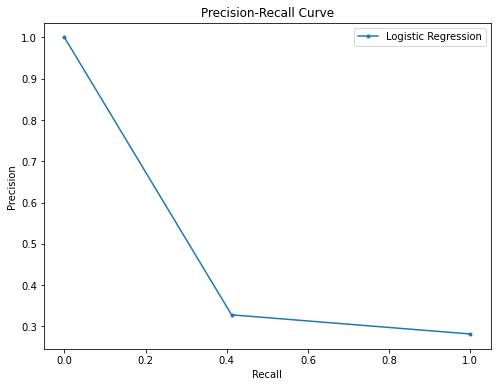

In [24]:
# model evaluation

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)


# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plotting the Precision-Recall curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.savefig(f'../src/model outputs/logistic regression/duplication method Precision-Recall curve.png')

with open(f'../src/model outputs/logistic regression/duplication_method.txt','w') as h:
    h.write(f"Accuracy:{accuracy} \n\n")
    h.write(f"Classification Report:\n{report} \n\n")
    h.write(f"ROC-AUC Score:{roc_auc:.4f}\n\n")
    h.write(f"Confusion matrix:\n{matrix}\n\n")   

### Logistic Regression for the Arbitrary Dataset

In [25]:
#logistic regression for arb_df:

X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

# feature scaling:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handling class imbalance:
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train_scaled, y_train)


#hyperparameter tuning

log_model = LogisticRegression(random_state=42, max_iter=1000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'] }


# cross validation
grid_search = GridSearchCV(log_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [26]:
# Prediction

y_pred = grid_search.best_estimator_.predict(X_test_scaled)

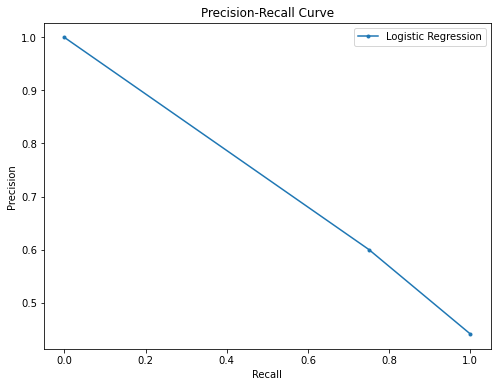

In [27]:
# model evaluation

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)


# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plotting the Precision-Recall curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.savefig(f'../src/model outputs/logistic regression/arbitrary method Precision-Recall curve.png')

with open(f'../src/model outputs/logistic regression/arbitrary_method.txt','w') as h:
    h.write(f"Accuracy:{accuracy} \n\n")
    h.write(f"Classification Report:\n{report} \n\n")
    h.write(f"ROC-AUC Score:{roc_auc:.4f}\n\n")
    h.write(f"Confusion matrix:\n{matrix}\n\n")   

### Random Forest for the Duplication Dataset

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

#using SMOTE to handle imbalance in dataset
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('dup_model', RandomForestClassifier(random_state=42))
])

#tuning hyperparameters to reduce chances of overfitting
param_grid = {
    'dup_model__n_estimators': [50, 100, 200],
    'dup_model__max_depth': [5, 10, 15],
    'dup_model__min_samples_leaf': [1, 5, 10],
    'dup_model__max_features': ['sqrt', 'log2']
}


# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,         
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

#using the best model for predictions:
best_model = grid_search.best_estimator_


In [29]:
# Predicting on the test set
y_pred = best_model.predict(X_test)  

In [30]:
#model evaluation

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)


#checking for overfitting 

train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)


# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)


# Correlation with target
corr = pd.concat([X_train, y_train], axis=1).corr(method='spearman')
matrix = corr['Cambridge?'].sort_values(ascending=False)

####
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
imp={}
for i in result.importances_mean.argsort()[::-1]:
    feature_name = X_test.columns[i]
    importance_value = result.importances_mean[i]
    imp[feature_name] = round(importance_value, 4)
    
    
with open(f'../src/model outputs/random forest/duplication_method.txt','w') as h:
    h.write(f"Accuracy:{accuracy}\n\n")
    h.write(f"Classification Report:\n{report} \n\n")
    h.write(f"Training accuracy:{train_accuracy:.4f}\n\n")
    h.write(f"Cross validation accuracy:{cv_scores.mean():.4f}\n\n")
    h.write(f"Checking for data leakage:\n{len(set(X_train.index) & set(X_test.index))}\n\n")
    h.write(f"Correlation matrix:\n{matrix}\n\n")
    h.write(f"Feature Importance:\n{imp}\n\n")


### Random Forest for the Arbitrary Dataset

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

#using SMOTE to handle imbalance in dataset
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('dup_model', RandomForestClassifier(random_state=42))
])

#tuning hyperparameters to reduce chances of overfitting
param_grid = {
    'dup_model__n_estimators': [50, 100, 200],
    'dup_model__max_depth': [5, 10, 15],
    'dup_model__min_samples_leaf': [1, 5, 10],
    'dup_model__max_features': ['sqrt', 'log2']
}


# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,         
    scoring='accuracy',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

#using the best model for predictions:
best_model = grid_search.best_estimator_

In [32]:
# Predicting on the test set
y_pred = best_model.predict(X_test)  

In [33]:
#model evaluation

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)


#checking for overfitting 

train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)


# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)


# Correlation with target
corr = pd.concat([X_train, y_train], axis=1).corr(method='spearman')
matrix = corr['Cambridge?'].sort_values(ascending=False)

####
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
imp={}
for i in result.importances_mean.argsort()[::-1]:
    feature_name = X_test.columns[i]
    importance_value = result.importances_mean[i]
    imp[feature_name] = round(importance_value, 4)
    
    
with open(f'../src/model outputs/random forest/arbitrary_method.txt','w') as h:
    h.write(f"Accuracy:{accuracy}\n\n")
    h.write(f"Classification Report:\n{report} \n\n")
    h.write(f"Training accuracy:{train_accuracy:.4f}\n\n")
    h.write(f"Cross validation accuracy:{cv_scores.mean():.4f}\n\n")
    h.write(f"Checking for data leakage:\n{len(set(X_train.index) & set(X_test.index))}\n\n")
    h.write(f"Correlation matrix:\n{matrix}\n\n")
    h.write(f"Feature Importance:\n{imp}\n\n")


### Extra Trees for the Duplication Dataset

In [34]:

X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

et_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('dup_class', ExtraTreesClassifier(random_state=42))
])

# Define a simple hyperparameter grid to test
param_grid_et = {
    'dup_class__n_estimators': [100, 200],
    'dup_class__max_depth': [None, 10, 20],
    'dup_class__min_samples_split': [2, 5],
    'dup_class__min_samples_leaf': [1, 2]
}

# Set up GridSearchCV
grid_search_et = GridSearchCV(
    et_pipeline, 
    param_grid_et, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1
)

# Fit the model
grid_search_et.fit(X_train, y_train)

# Best Extra Trees model
best_et_model = grid_search_et.best_estimator_

# Evaluate
et_predictions = best_et_model.predict(X_test)

In [35]:
# Predicting on the test set
y_pred = best_et_model.predict(X_test)  

In [36]:
#model evaluation

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)


#checking for overfitting 

train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)


# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)


# Correlation with target
corr = pd.concat([X_train, y_train], axis=1).corr(method='spearman')
matrix = corr['Cambridge?'].sort_values(ascending=False)

####
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
imp={}
for i in result.importances_mean.argsort()[::-1]:
    feature_name = X_test.columns[i]
    importance_value = result.importances_mean[i]
    imp[feature_name] = round(importance_value, 4)
    
    
with open(f'../src/model outputs/extra trees/duplication_method.txt','w') as h:
    h.write(f"Accuracy:{accuracy}\n\n")
    h.write(f"Classification Report:\n{report} \n\n")
    h.write(f"Training accuracy:{train_accuracy:.4f}\n\n")
    h.write(f"Cross validation accuracy:{cv_scores.mean():.4f}\n\n")
    h.write(f"Checking for data leakage:\n{len(set(X_train.index) & set(X_test.index))}\n\n")
    h.write(f"Correlation matrix:\n{matrix}\n\n")
    h.write(f"Feature Importance:\n{imp}\n\n")


### Extra Trees for the Arbitrary Dataset

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

et_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('arb_class', ExtraTreesClassifier(random_state=42))
])

# Define a simple hyperparameter grid to test
param_grid_et = {
    'arb_class__n_estimators': [100, 200],
    'arb_class__max_depth': [None, 10, 20],
    'arb_class__min_samples_split': [2, 5],
    'arb_class__min_samples_leaf': [1, 2]
}

# Set up GridSearchCV
grid_search_et = GridSearchCV(
    et_pipeline, 
    param_grid_et, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1
)

# Fit the model
grid_search_et.fit(X_train, y_train)

# Best Extra Trees model
best_et_model = grid_search_et.best_estimator_

# Evaluate
et_predictions = best_et_model.predict(X_test)


In [38]:
# Predicting on the test set
y_pred = best_et_model.predict(X_test)  


In [39]:
#model evaluation

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)


#checking for overfitting 

train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)


# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)


# Correlation with target
corr = pd.concat([X_train, y_train], axis=1).corr(method='spearman')
matrix = corr['Cambridge?'].sort_values(ascending=False)

####
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
imp={}
for i in result.importances_mean.argsort()[::-1]:
    feature_name = X_test.columns[i]
    importance_value = result.importances_mean[i]
    imp[feature_name] = round(importance_value, 4)
    
    
with open(f'../src/model outputs/extra trees/arbitrary_method.txt','w') as h:
    h.write(f"Accuracy:{accuracy}\n\n")
    h.write(f"Classification Report:\n{report} \n\n")
    h.write(f"Training accuracy:{train_accuracy:.4f}\n\n")
    h.write(f"Cross validation accuracy:{cv_scores.mean():.4f}\n\n")
    h.write(f"Checking for data leakage:\n{len(set(X_train.index) & set(X_test.index))}\n\n")
    h.write(f"Correlation matrix:\n{matrix}\n\n")
    h.write(f"Feature Importance:\n{imp}\n\n")
